# Model selection using GpABC

## Problem formulation

This notebook illustrates how to perform model selection using the algorithm described in (Toni et al, 2009). The example here is adapted from the SIR (susceptible-infected-recovered) model in Section 3.3 of the paper.

The example gives two models that describe the evolution of the number of of susceptible ($S$), infected ($I$) and recovered ($R$) individuals in a population (the number of dead individuals is not included in the model).

There are two possible models, both of which are described below. Given some observed data on the number of individuals in each disease state over time we wish to determine which of the two models is better supported by these data. The data was generated using the first model so the algorithm should reflect this.

### Model 1

A basic SIR model assumes that each individual can be infected once and is then able to infect other individuals immediately. 

The model is given by

\begin{align}
    \dot{S} &= \alpha - \gamma S I - d S, \\
    \dot{I} &= \gamma S I - v I - d I, \\
    \dot{R} &= v I - d R \, ,
\end{align}

where the notation $\dot{x}$ denotes $\text{d}x/\text{d}t$.

The paramters of this model are the birth rate $\alpha$, the infection rate $\gamma$, the recovery rate $v$ and the death rate $d$. Note that the death rate is constant for all three disease states.

### Model 2

A slightly more sophisticated model includes a time delay between an individual becoming infected and being able to infect others by introducing an additional latent state ($L$). This model is given by

\begin{align}
    \dot{S} &= \alpha - \gamma S I - d S , \\
    \dot{L} &= \gamma S I - \delta L - d L , \\
    \dot{I} &= \delta L - v I - d I , \\
    \dot{R} &= v I - d R \, ,
\end{align}

where $\delta$ is the transition rate from latent to infected.

# To run this notebook locally:
* Make sure that [Jupyter](https://jupyter.org/) is installed, along with [Julia](https://www.julialang.org/) and its [Jupyter Kernel](https://github.com/JuliaLang/IJulia.jl).
* Clone or download [GpABC.jl](https://github.com/tanhevg/GpABC.jl) to your machine.
* Run `jupyter` from the `examples` directory of the local copy of `GpABC.jl`:
```bash
$ cd GpABC.jl/examples
$ jupyter notebook model-selection-example.ipynb
```
* The first line of the cell below activates the local project environment and downloads all the dependencies.

In [ ]:
import Pkg; Pkg.activate("."); Pkg.resolve()
using GpABC, OrdinaryDiffEq, Distributions, Distances, Plots
pyplot()

Prepare the observed data into the correct format: a 2D array with size (number of trajectories, number of time points).

The observed data contains information the number of susceptible, infected and recovered individuals at 13 time points.

In [4]:
times = [0.0, 0.6, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
data = [[ 20.     ,  10.     ,   0.     ],
       [  0.12313,  13.16813,   9.42344],
       [  0.12102,   7.17251,  11.18957],
       [  0.09898,   2.36466,  10.0365 ],
       [  0.37887,   0.92019,   6.87117],
       [  1.00661,   0.61958,   4.44955],
       [  1.20135,   0.17449,   3.01271],
       [  1.46433,   0.28039,   1.76431],
       [  1.37789,   0.0985 ,   1.28868],
       [  1.57073,   0.03343,   0.81813],
       [  1.4647 ,   0.28544,   0.52111],
       [  1.24719,   0.10138,   0.22746],
       [  1.56065,   0.21671,   0.19627]]

data = hcat(data...); 

Next, we define the models. As in other GpABC functions, the model is represented using a function that takes parameters as an argument and returns trajectories that are the solution to the differential equation system. This is called the `simulator_function`. The solution shuuld have the same shape as the reference data, which is (number of trajectories, number of time points).

This means that for the second model, which has 4 states, we need to modify the `simulator_function` in order to ignore the solution for the latent state $L$ as we have no reference data for that trajectory. 

We also need to define different initial conditions for the two models as the first model has 3 states and the second has 4.

In [14]:
# Need initial conditions for each model since they have different numbers of states
ic1 = [20.0, 10.0, 0.0]
ic2 = [20.0, 0.0, 10.0, 0.0]
ics = [ic1, ic2]

# Define a simulator function for each model. Each function returns the solution of the model
# as a 2D array for some parameter values. The appropriate ODE is solved at the same time 
# points as the observed data
function simulator1(params::Array{Float64,1})
    
    # p = (alpha, gamma, d, v)
    # x = (S, I, R)
    function model1(dx, x, p, t)
        dx[1] = p[1] - p[2]*x[1]*x[2] - p[3]*x[1] # dS/dt = alpha - gamma*S*I - d*S
        dx[2] = p[3]*x[1]*x[2] - p[4]*x[2] - p[3]*x[2] # dI/dt = gamma*S*I - v*I - d*I
        dx[3] = p[4]*x[2] - p[3]*x[3] # dR/dt = v*I - d*R
    end
    
    return(Array{Float64,2}(
        solve(ODEProblem(model1, ics[1], (times[1], times[end]), params),
                RK4(), saveat=times, force_dtmin=true)))
end

function simulator2(params::Array{Float64,1})

    # p = (alpha, gamma, d, v, delta)
    # x = (S, L, I, R)
    function model2(dx, x, p, t)
        dx[1] = p[1] - p[2]*x[1]*x[3] - p[3]*x[1] # dS/dt = alpha - gamma*S*I - d*S
        dx[2] = p[2]*x[1]*x[3] - p[5]*x[2] - p[3]*x[2] # dL/dt = gamma*S*I - delta*L - d*L
        dx[3] = p[5]*x[2] - p[4]*x[3] - p[3]*x[3] # dI/dt = delta*L - v*I - d*I
        dx[4] = p[4]*x[3] - p[3]*x[4] # dR/dt = v*I - d*R
    end
    
    # Model2 contains the species L, which is not measured - we remove it from the returned ODE solution
    # so that it can be compared to the reference data "data", which only contains S, I and R
    return(Array{Float64,2}(
        solve(ODEProblem(model2, ics[2], (times[1], times[end]), params),
                RK4(), saveat=times, force_dtmin=true)))[[1,3,4],:]
end;

We also need a set of priors for each model, as well as a summary statistic and threshold schedule. We will compare the full model solution with the data, which is the "keep_all" summary statistic. The model prior will be the default discrete uniform prior with span 2 (as there are two models).

In [6]:
#
# Priors and initial conditions - these are model-specfic as each model can 
# have different numbers of parameters/species
#
priors1 = [Uniform(0.0, 5.0) for i in 1:4]
priors2 = vcat([Uniform(0.0, 5.0) for i in 1:4], Uniform(0.0, 10.0))
priors3 = vcat([Uniform(0.0, 5.0) for i in 1:4], Uniform(0.0, 10.0))

threshold_schedule = [20, 15, 10, 5, 3, 2.5, 2, 1.7, 1.5]
summary_statistic = "keep_all";

We are now ready to perform the model selection computation, accepting 200 particles at each population.

First, we will do this using full model simulations:

In [15]:
n_particles = 200

ms_sim_result = SimulatedModelSelection(data,
    [simulator1, simulator2],
    [priors1, priors2],
    threshold_schedule,
    n_particles);

┌ Info: GpABC model selection simulation  Population 1 - ABC Rejection ϵ = 20.0
└ @ GpABC /data/.julia/packages/GpABC/TIl7C/src/abc/model_selection.jl:9
┌ Info: GpABC model selection simulation
│ Completed 718 iterations, accepting 200 particles in total.
│ Number of accepted parameters by model:
│ Model 1: 94	Model 2: 106
└ @ GpABC /data/.julia/packages/GpABC/TIl7C/src/abc/model_selection.jl:113
┌ Info: GpABC model selection simulation  Population 2 - ABC SMC ϵ = 15.0
└ @ GpABC /data/.julia/packages/GpABC/TIl7C/src/abc/model_selection.jl:24
┌ Info: GpABC model selection simulation
│ Completed 1090 iterations, accepting 200 particles in total.
│ Number of accepted parameters by model: 
│ Model 1: 40	Model 2: 160
└ @ GpABC /data/.julia/packages/GpABC/TIl7C/src/abc/model_selection.jl:307
┌ Info: GpABC model selection simulation  Population 3 - ABC SMC ϵ = 10.0
└ @ GpABC /data/.julia/packages/GpABC/TIl7C/src/abc/model_selection.jl:24
┌ Info: GpABC model selection simulation
│ Completed 40

A plot recipe allows this result to be plotted easily:

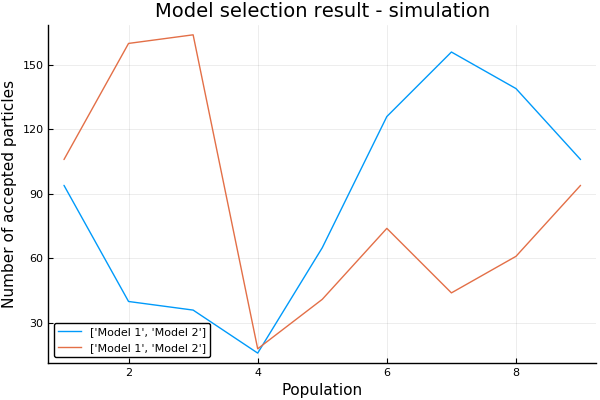

In [16]:
plot(ms_sim_result, title="Model selection result - simulation")

The first model is correctly identified as the correct one.

Now do the same computation using emulation. The only difference between the simulation and emulation function call is that we specify the number of design points as the first argument when using emulation.

We will use 200 design points.

In [17]:
ms_emu_result = EmulatedModelSelection(data,
    [simulator1, simulator2],
    [priors1, priors2],
    threshold_schedule,
    n_particles,
    200;
    summary_statistic = "keep_all",
    distance_function=Distances.euclidean);

┌ Info: GpABC model selection emulation  Population 1 - ABC Rejection ϵ = 20.0
└ @ GpABC /data/.julia/packages/GpABC/TIl7C/src/abc/model_selection.jl:9
┌ Info: GpABC model selection emulation
│ Completed 22 iterations, accepting 200 particles in total.
│ Number of accepted parameters by model: 
│ Model 1: 108	Model 2: 92
└ @ GpABC /data/.julia/packages/GpABC/TIl7C/src/abc/model_selection.jl:212
┌ Info: GpABC model selection emulation  Population 2 - ABC SMC ϵ = 15.0
└ @ GpABC /data/.julia/packages/GpABC/TIl7C/src/abc/model_selection.jl:24
┌ Info: GpABC model selection emulation
│ Completed 39 iterations, accepting 200 particles in total.
│ Number of accepted parameters by model: 
│ Model 1: 29	Model 2: 171
└ @ GpABC /data/.julia/packages/GpABC/TIl7C/src/abc/model_selection.jl:398
┌ Info: GpABC model selection emulation  Population 3 - ABC SMC ϵ = 10.0
└ @ GpABC /data/.julia/packages/GpABC/TIl7C/src/abc/model_selection.jl:24
┌ Info: GpABC model selection emulation
│ Completed 83 iterati

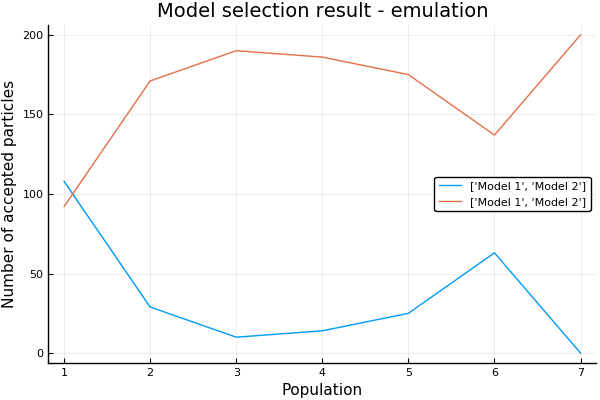

In [18]:
plot(ms_emu_result, title="Model selection result - emulation")

## References

[Toni, T., Welch, D., Strelkowa, N., Ipsen, A. and Stumpf, M.P., 2009. Approximate Bayesian computation scheme for parameter inference and model selection in dynamical systems. *Journal of the Royal Society Interface, 6*(31), pp.187-202.](http://rsif.royalsocietypublishing.org/content/royinterface/6/31/187.full.pdf)